## Reinforcement Learning
<b>Objective:</b> To develop a Reinforcement Learning (RL) agent that navigates an environment to find a beehive while avoiding factories and areas with smoke.
This program implements Q-Learnings:

## Necessary Imports

In [42]:
import numpy as np
import pylab as plt

import networkx as nx

# Collapse-show
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings('ignore')

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


Saving figure Beehive_network1


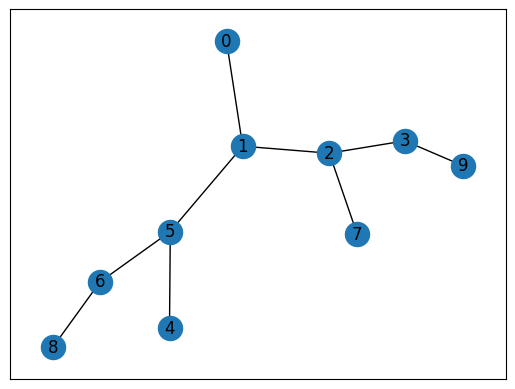

In [43]:
# map cell to cell, add circular cell to goal point
points_list = [(0,1), (1,5), (5,6), (5,4), (1,2), (2,3), (2,7), (3, 9), (6, 8)]

# Define the goal node for agent to reach
goal = 9 

# Initialize a new graph
G=nx.Graph()
G.add_edges_from(points_list)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)

# Save and display the graph
save_fig('Beehive_network1', tight_layout=False)
plt.show()

In [44]:
# Set the size of the matrix to the number of nodes which is 10
MATRIX_SIZE = 10

# Initialize the reward matrix with -1 for all paths, assuming they are 'bad' by default
R = np.matrix(np.ones(shape=(MATRIX_SIZE, MATRIX_SIZE)))
R *= -1

In [45]:
# Assign zeros to paths and 100 to goal-reaching point
for point in points_list:
    if point[0] < MATRIX_SIZE and point[1] < MATRIX_SIZE:
        if point[1] == goal:
            R[point] = 100
        else:
            R[point] = 0

        if point[0] == goal:
            R[point[::-1]] = 100
        else:
            # reverse of point
            R[point[::-1]] = 0

# Add goal point round trip
R[goal, goal] = 100

R

matrix([[ -1.,   0.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
        [  0.,  -1.,   0.,  -1.,  -1.,   0.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,   0.,  -1.,   0.,  -1.,  -1.,  -1.,   0.,  -1.,  -1.],
        [ -1.,  -1.,   0.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1., 100.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,   0.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,   0.,  -1.,  -1.,   0.,  -1.,   0.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,   0.,  -1.,  -1.,   0.,  -1.],
        [ -1.,  -1.,   0.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,   0.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,   0.,  -1.,  -1.,  -1.,  -1.,  -1., 100.]])

## Q-Learning without environment

In [46]:
# Initialize a Q-matrix with zeros for all state-action pairs, this matrix will
# eventually hold the learned values that the agent uses to pick actions
Q = np.matrix(np.zeros([MATRIX_SIZE,MATRIX_SIZE]))

# Set the learning parameter gamma, which discounts the future reward. It's a measure
# of how much we prioritize immediate reward over future rewards
gamma = 0.9

# Define the initial state of the agent, in this case, the agent starts at state 1
initial_state = 1

# Define a function to find available actions for a given state.
# An available action is one that leads to a state with a non-negative reward.
def available_actions(state):
    current_state_row = R[state,]
    av_act = np.where(current_state_row >= 0)[1]
    return av_act

# Get the available actions for the initial state
available_act = available_actions(initial_state)

# Define a function to randomly choose the next action from the range of available actions.
# This is part of the exploration strategy of the agent.
def sample_next_action(available_actions_range):
    next_action = int(np.random.choice(available_act,1))
    return next_action

# Sample an action to take from the available actions
action = sample_next_action(available_act)

# Define a function to update the Q-matrix using the most recent action and the learning parameter.
def update(current_state, action, gamma):
    # Find the action with the highest Q-value for the next state
    max_index = np.where(Q[action,] == np.max(Q[action,]))[1]
    
    # If there are multiple actions with the same maximum Q-value, randomly choose one
    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size = 1))
    else:
        max_index = int(max_index)
    max_value = Q[action, max_index]
    
    # Update the Q-matrix with the new Q-value for the current state-action pair
    Q[current_state, action] = R[current_state, action] + gamma * max_value
    print('max_value', R[current_state, action] + gamma * max_value)
    
    # If the Q-matrix has non-zero values, normalize it and return the sum as a score
    if (np.max(Q) > 0):
        return(np.sum(Q/np.max(Q)*100))
    else:
        # If the Q-matrix is still zero, return 0 as the score
        return (0)
    
# Perform the update function for the initial state and chosen action
update(initial_state, action, gamma)


max_value 0.0


0

### Training

In [47]:
# Training loop for the RL agent to learn from interactions with the environment
scores = []
history1 = []  # Initialize an empty list to store the data

# Run the training loop for 10,000 iterations
for i in range(10_000):
    history1.append(Q[0, 1])
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_act = available_actions(current_state)
    action = sample_next_action(available_act)
    score = update(current_state,action,gamma)
    scores.append(score)
    print ('Score:', str(score))

history1 = np.array(history1)

# Print the trained Q matrix
print("Trained Q matrix:")
# Normalize the Q matrix by the maximum value in Q to scale the values to a percentage
print(Q/np.max(Q)*100) 

max_value 0.0
Score: 0
max_value 0.0
Score: 0
max_value 0.0
Score: 0
max_value 0.0
Score: 0
max_value 0.0
Score: 0
max_value 0.0
Score: 0
max_value 0.0
Score: 0
max_value 0.0
Score: 0
max_value 100.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 100.0
Score: 200.0
max_value 190.0
Score: 152.6315789473684
max_value 271.0
Score: 170.1107011070111
max_value 0.0
Score: 170.1107011070111
max_value 0.0
Score: 170.1107011070111
max_value 0.0
Score: 170.1107011070111
max_value 0.0
Score: 170.1107011070111
max_value 243.9
Score: 260.1107011070111
max_value 0.0
Score: 260.1107011070111
max_value 0.0
Score: 260.1107011070111
max_value 0.0
Score: 260.1107011070111
max_value 0.0
Score: 260.1107011070111
max_value 0.0
Score: 260.1107011070111
max_value 0.0
Score: 260.1107011070111
max_value 0.0
Score: 260.1107011070111
max_value 0.0
Score: 260.1107011070111
max_value 0.0
Score: 260.1107011

Most efficient path:
[0, 1, 2, 3, 9]


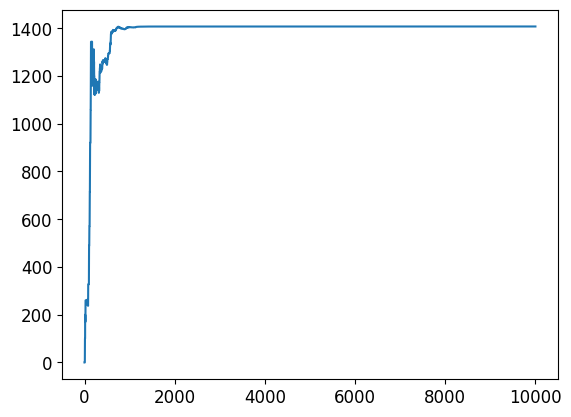

In [48]:
# Testing phase to evaluate the performance of the trained agent
# Start the agent at the initial state (0 in this case)
current_state = 0
steps = [current_state]  # List to record the steps taken by the agent

# Continue taking steps until the goal state (state 9) is reached
while current_state != 9:

    # Find the action (next step) with the highest Q-value for the current state
    next_step_index = np.where(Q[current_state,] == np.max(Q[current_state,]))[1]
    
    # If there are multiple actions with the same max Q-value, choose one randomly
    if next_step_index.shape[0] > 1:
        next_step_index = int(np.random.choice(next_step_index, size=1))
    else:
        # If there's only one action with max Q-value, choose that one
        next_step_index = int(next_step_index)
    
    # Append the chosen next step to the steps list
    steps.append(next_step_index)
    
    # Update the current state to the next step
    current_state = next_step_index

# Print the most efficient path determined by the agent
print("Most efficient path:")
print(steps)

# Plot the scores from the training phase to visualize the learning progress
plt.plot(scores)

# Save and display the plot
plt.savefig('Beehive_plot1')
plt.show()

## Q-Learning with environment
Assign node 2 as having bees and nodes 4,5,6 as having smoke Bees are good and smoke are bad in finding Beehive. 

Saving figure Beehive_network2


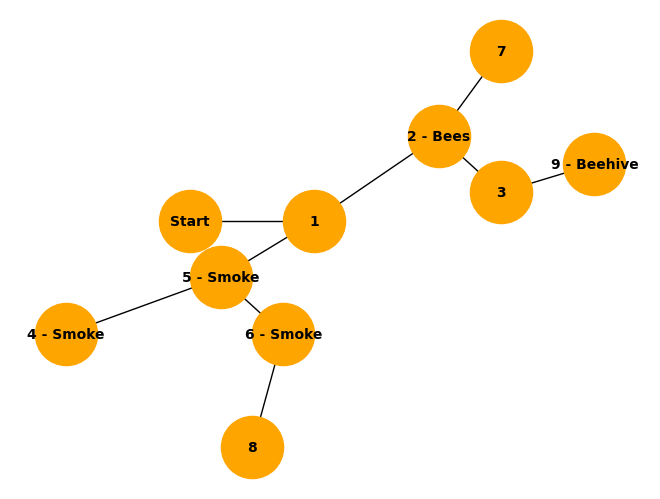

In [49]:
# Define the edges in your graph
points_list = [(0,1), (1,5), (5,6), (5,4), (1,2), (2,3), (2,7), (3, 9), (6, 8)]
#points_list = [(0, 1), (1, 5), (5, 6), (5, 4), (1, 2), (2, 3), (2, 7), (3, 9), (3, 10)]
bees = [2] # Assign 2 for bee location
smoke = [4,5,6] ## Assign 4, 5 and 6 for smoke location

# Create the graph and add edges
G = nx.Graph()
G.add_edges_from(points_list)

# Define your custom mapping
mapping = {0: 'Start', 1: '1', 2: '2 - Bees', 3: '3', 4: '4 - Smoke', 5: '5 - Smoke', 
           6: '6 - Smoke', 7: '7', 8: '8', 9: '9 - Beehive'}
H = nx.relabel_nodes(G, mapping)

# Custom positions for nodes to create a zigzag (bee hive) pattern
# The positions will be manually set to match your description
pos = {'Start': (0, 0), '1': (2, 0), '2 - Bees': (4, 1.5), '3': (5, 0.5), 
       '4 - Smoke': (-2, -2), '5 - Smoke': (0.5, -1), '6 - Smoke': (1.5, -2), 
       '7': (5, 3), '8': (1, -4),'9 - Beehive': (6.5, 1)}

# Now, draw the graph
nx.draw(H, pos, with_labels=True, node_size=2000, node_color='orange', font_size=10, font_weight='bold')

# Save and display the plot
save_fig('Beehive_network2', tight_layout=False)
plt.show()

In [50]:
# Re-initialize the Q matrix for a new run
# The Q matrix stores the learned values (Q-values) for each state-action pair
Q = np.matrix(np.zeros([MATRIX_SIZE, MATRIX_SIZE]))

# Initialize two matrices to record environmental data regarding bees and smoke
enviro_bees = np.matrix(np.zeros([MATRIX_SIZE, MATRIX_SIZE]))
enviro_smoke = np.matrix(np.zeros([MATRIX_SIZE, MATRIX_SIZE]))

# Set the initial state of the agent
initial_state = 1

# Function to determine available actions from the current state
# Available actions are those that lead to a state with a non-negative reward
def available_actions(state):
    current_state_row = R[state,]
    av_act = np.where(current_state_row >= 0)[1]
    return av_act

# Function to randomly choose the next action from available actions
# This is part of the agent's exploration strategy
def sample_next_action(available_actions_range):
    next_action = int(np.random.choice(available_act, 1))
    return next_action

# Function to collect environmental data based on the agent's action
# This data includes the presence of bees ('b') or smoke ('s') in a state
def collect_environmental_data(action):
    found = []
    if action in bees:
        found.append('b')  # 'b' is added to the list if bees are found in the action

    if action in smoke:
        found.append('s')  # 's' is added to the list if smoke is found in the action
    return found


In [51]:
# Determine available actions from the initial state
available_act = available_actions(initial_state)

# Choose an action for the agent to take from the available actions
action = sample_next_action(available_act)

# Function to update the Q matrix based on the agent's actions and the learning algorithm
def update(current_state, action, gamma):
    # Find the action for the current state with the highest Q-value
    max_index = np.where(Q[action,] == np.max(Q[action,]))[1]
  
    # If there are multiple actions with the same max Q-value, choose one randomly
    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size=1))
    else:
        # If there's only one action with max Q-value, choose that one
        max_index = int(max_index)
    max_value = Q[action, max_index]
  
    # Update the Q-value for the current state-action pair
    Q[current_state, action] = R[current_state, action] + gamma * max_value
    # Print the updated max_value for debugging purposes
    print('max_value', R[current_state, action] + gamma * max_value)
  
    # Collect environmental data based on the current action
    environment = collect_environmental_data(action)
    # Update environmental matrices based on the presence of bees or smoke
    if 'b' in environment: 
        enviro_bees[current_state, action] += 1
    if 's' in environment: 
        enviro_smoke[current_state, action] += 1
  
    # Normalize the Q matrix and return the sum as a performance score
    # if the Q matrix has non-zero values
    if (np.max(Q) > 0):
        return np.sum(Q/np.max(Q)*100)
    else:
        # Return 0 if the Q matrix is still uninitialized
        return 0

# Perform the update operation for the initial state and the chosen action
# with the specified gamma (learning rate)
update(initial_state, action, gamma)


max_value 0.0


0

### Training

In [52]:
# Initialize a list to store scores from each iteration of the training process
scores = []
history2 = []  # Initialize an empty list to store the data

# Run the training loop for 10,000 iterations
for i in range(10_000):
    history2.append(Q[0, 1])
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_act = available_actions(current_state)
    action = sample_next_action(available_act)
    score = update(current_state,action,gamma)

history2 = np.array(history2)

# Print the environmental matrices
# These matrices record the number of times bees or smoke were found in each state-action pair
print('Bees Found')
print(enviro_bees)
print('Smoke Found')
print(enviro_smoke)

max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 100.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 90.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 90.0
max_value 0.0
max_value 181.0
max_value 162.9
max_value 162.9
max_value 0.0
max_value 162.9
max_value 246.61
max_value 146.61
max_value 146.61
max_value 146.61
max_value 0.0
max_value 146.61
max_value 0.0
max_value 246.61
max_value 146.61
max_value 146.61
max_value 131.949
max_value 0.0
max_value 146.61
max_value 0.0
max_value 146.61
max_value 0.0
max_value 221.949
max_value 221.949
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 199.75410000000002
max_value 131.949
max_value 0.0
max_value 199.75410000000002
max_value 221.949
max_value 221.949
max_value 118.75410000000001
max_value 299.7541
max_value 199.75410000000002
max_value 0.0
max_value 179.77869
max_value 0.0
max_value

In [53]:
# Initialize the Q matrix with zeros for all state-action pairs.
# and also hold the learned values (Q-values)
Q = np.matrix(np.zeros([MATRIX_SIZE,MATRIX_SIZE]))

# subtract bees with smoke, this gives smoke a negative effect
enviro_matrix = enviro_bees - enviro_smoke

# Get available actions in the current state
available_act = available_actions(initial_state) 

# Sample next action to be performed
action = sample_next_action(available_act)

# This function updates the Q matrix according to the path selected and the Q 
# learning algorithm
def update(current_state, action, gamma):
    
    max_index = np.where(Q[action,] == np.max(Q[action,]))[1]

    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size = 1))
    else:
        max_index = int(max_index)
    max_value = Q[action, max_index]
    
    # Update the Q-value for the current state-action pair.
    # The update rule combines the immediate reward with the discounted maximum future reward.
    Q[current_state, action] = R[current_state, action] + gamma * max_value
    print('max_value', R[current_state, action] + gamma * max_value)

    # Collect environmental data based on the current action and update the environmental matrix.
    # This data includes the presence of bees ('b') and smoke ('s').
    environment = collect_environmental_data(action)
    if 'b' in environment: 
        enviro_matrix[current_state, action] += 1
    if 's' in environment: 
        enviro_matrix[current_state, action] -= 1
    
    # Return the normalized sum of the Q matrix as a performance score.
    # This score reflects how well the agent is learning over time.
    return(np.sum(Q/np.max(Q)*100))
    
# Perform the update operation for the initial state and the chosen action.
update(initial_state,action,gamma)

max_value 0.0


nan

In [54]:
# Create a snapshot of the current environmental matrix.
# This snapshot will be used to make decisions based on the environment,
# such as the presence of bees or smoke encountered so far.
enviro_matrix_snap = enviro_matrix.copy()

# Determine available actions from a given state
# while also considering environmental factors 
# such as the presence of bees and smoke.
def available_actions_with_enviro_help(state):
    # Get the row from the R matrix corresponding to the current state.
    current_state_row = R[state,]
    # Find actions that lead to a state with a non-negative reward.
    av_act = np.where(current_state_row >= 0)[1]
    # if there are multiple routes, dis-favor anything negative
    env_pos_row = enviro_matrix_snap[state,av_act]
    
    if (np.sum(env_pos_row < 0)):
        # filter out actions that lead to negative environmental outcomes.
        temp_av_act = av_act[np.array(env_pos_row)[0]>=0]
        # If there are any remaining actions after filtering, update the available actions.
        if len(temp_av_act) > 0:
            print('going from:',av_act)
            print('to:',temp_av_act)
            av_act = temp_av_act
    return av_act

### Training

In [55]:
# Start of the training process for the reinforcement learning agent
scores = []  # Initialize an empty list to store the performance scores from each iteration
history3 = []  # Initialize an empty list to store the data

# Run the training loop for a total of 10,000 iterations
for i in range(10_000):
    history3.append(Q[0, 1])
    # Select a random current state from all possible states for the agent to start
    # This introduces variability in the training process and ensures diverse experience for the agent
    current_state = np.random.randint(0, int(Q.shape[0]))
    
    # Determine the available actions from the current state, considering environmental factors
    # This function takes into account the presence of bees and smoke, as learned from previous iterations,
    # and adjusts the available actions accordingly to make better-informed decisions
    available_act = available_actions_with_enviro_help(current_state)
    
    # Randomly choose one of the available actions to perform
    # This introduces an element of exploration, allowing the agent to try different paths and learn from them
    action = sample_next_action(available_act)
    
    # Update the Q matrix based on the current state, selected action, and learning rate (gamma)
    # The function returns a score indicating how well the agent is learning to make decisions
    score = update(current_state, action, gamma)
    
    # Append the obtained score to the scores list for later analysis
    scores.append(score)
    
    # Print the score for this iteration to monitor the agent's performance
    print('Score:', str(score))
history3 = np.array(history3)

going from: [0 2 5]
to: [0 2]
max_value 0.0
Score: nan
going from: [5 8]
to: [8]
max_value 0.0
Score: nan
max_value 100.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 90.0
Score: 190.0
max_value 0.0
Score: 190.0
going from: [1 4 6]
to: [1]
max_value 0.0
Score: 190.0
max_value 90.0
Score: 190.0
max_value 181.0
Score: 149.72375690607734
max_value 0.0
Score: 149.72375690607734
max_value 0.0
Score: 149.72375690607734
going from: [1 4 6]
to: [1]
max_value 0.0
Score: 149.72375690607734
max_value 181.0
Score: 149.72375690607734
max_value 0.0
Score: 149.72375690607734
going from: [0 2 5]
to: [0 2]
max_value 0.0
Score: 149.72375690607734
max_value 0.0
Score: 149.72375690607734
max_value 162.9
Score: 239.72375690607734
max_value 146.61
Score: 320.72375690607737
max_value 0.0
Score: 320.72375690607737
going from: [0 2 5]
to: [0 2]
max_value 146.61
Score: 401.72375690607737
max_value 0.0
Score: 401.72375690607737
going from: [5 8]
to: [8]
max_value 0.0
Score: 401.72

Most efficient path:
[0, 1, 2, 3, 9]
Saving figure Beehive_plot2


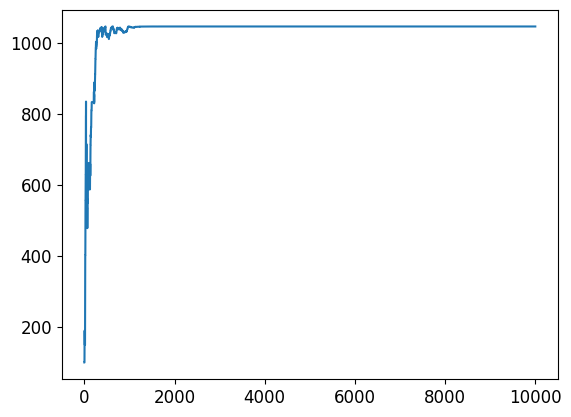

In [56]:
print("Most efficient path:")
print(steps)

plt.plot(scores)
save_fig('Beehive_plot2', tight_layout=False)
plt.show()

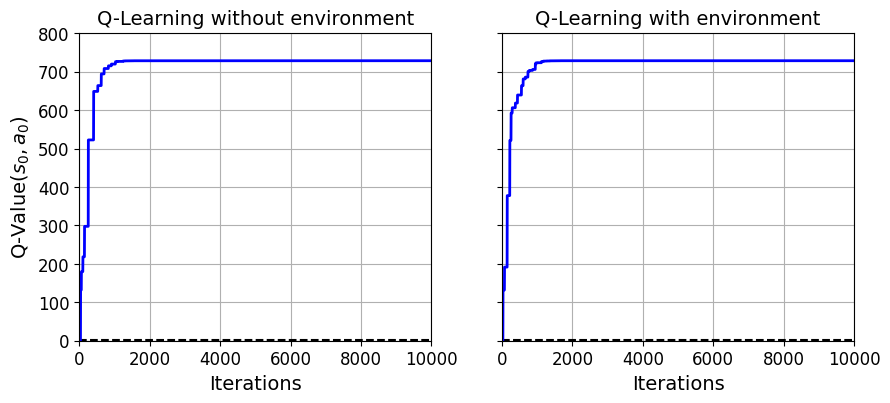

In [58]:
# Assuming history1 and history2 are correctly populated with Q-values for a specific state-action pair at each iteration
# Define the true Q-value for the state-action pair for comparison, if known.
true_Q_value =  2 

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Learning without environment", fontsize=14)
axes[1].set_title("Q-Learning with environment", fontsize=14)

# Determine the width of the plots based on the length of history arrays
width1 = len(history2)
width2 = len(history3)

for ax, width, history in zip(axes, (width1, width2), (history2, history3)):
    # Plot the true Q-value as a dashed line for comparison
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    
    # Plot the Q-values from the history array
    ax.plot(np.arange(width), history, "b-", linewidth=2)
    
    # Set up the axes
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, max(history) * 1.1])  # Set y-axis limit slightly above the max history value
    ax.grid(True)

# Save the plot to a file
plt.savefig("q_value_plot.png") 
plt.show()


## Summary

The graph displays the learning progress of two Q-Learning algorithms over 10,000 iterations: one that operates without an explicit model of the environment ("Q-Learning without environment") and another that incorporates environmental information ("Q-Learning with environment").

Both graphs show a rapid increase in Q-values during the initial phase, indicating that significant learning occurs early on. The Q-values quickly reach a plateau, demonstrating that the algorithms converge to an optimal policy in a relatively short number of iterations.

The "Q-Learning without environment" graph achieves a stable plateau slightly faster than the "Q-Learning with environment". This could be due to the simplicity of the model-free approach where the algorithm directly learns from interactions with the environment without the need for a predefined model.

In contrast, the "Q-Learning with environment" graph, while also showing quick convergence, includes slight fluctuations before stabilizing. This suggests that the incorporation of environmental information might introduce more complexity into the learning process, requiring the algorithm to process and integrate this additional data.

Overall, both approaches successfully converge to what appears to be a similar optimal Q-value, as indicated by the plateau. However, the approach without an environment model seems to achieve this with a smoother progression, whereas the environment-informed approach shows a bit more variability before convergence.